In [4]:
## Загрузка необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

RANDOM_SEED=42
random.seed(RANDOM_SEED)

In [5]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn import metrics

In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Alif/credit_train.csv',  sep=';',encoding='windows-1251')

In [ ]:
train_df.shape

(170746, 15)

In [ ]:
train_df.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,48,MAR,UMN,59998.00,10,1.6,0.770249,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,28,MAR,UMN,10889.00,6,1.1,0.248514,GRD,МОСКВА,43000.0,2.0,0.0,0
2,3,M,32,MAR,SPC,10728.00,12,1.1,0.459589,SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
3,4,F,27,DIV,SPC,12009.09,12,1.1,0.362536,GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
4,5,M,45,MAR,SPC,16908.89,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0


# Анализ и обработка данных

In [ ]:
## проверка на отсутсвующие значения

train_df.isnull().sum()

client_id                  0
gender                     0
age                        0
marital_status             0
job_position               0
credit_sum                 0
credit_month               0
tariff_id                  0
score_shk                  0
education                  0
living_region            192
monthly_income             1
credit_count            9230
overdue_credit_count    9230
open_account_flg           0
dtype: int64

In [ ]:
train_df.dropna(subset=['living_region', 'monthly_income'], inplace = True)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170553 entries, 0 to 170745
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170553 non-null  int64  
 1   gender                170553 non-null  object 
 2   age                   170553 non-null  int64  
 3   marital_status        170553 non-null  object 
 4   job_position          170553 non-null  object 
 5   credit_sum            170553 non-null  float64
 6   credit_month          170553 non-null  int64  
 7   tariff_id             170553 non-null  float64
 8   score_shk             170553 non-null  float64
 9   education             170553 non-null  object 
 10  living_region         170553 non-null  object 
 11  monthly_income        170553 non-null  float64
 12  credit_count          161341 non-null  float64
 13  overdue_credit_count  161341 non-null  float64
 14  open_account_flg      170553 non-null  int64  
dtype

In [ ]:
train_df['credit_count'].value_counts()

1.0     45232
2.0     36955
0.0     25773
3.0     23893
4.0     14097
5.0      7537
6.0      3911
7.0      1961
8.0      1007
9.0       476
10.0      220
11.0      129
12.0       74
13.0       33
14.0       15
15.0       13
17.0        5
16.0        4
19.0        3
18.0        2
21.0        1
Name: credit_count, dtype: int64

In [ ]:
train_df['overdue_credit_count'].value_counts()

0.0    153968
1.0      7319
2.0        49
3.0         5
Name: overdue_credit_count, dtype: int64

<Axes: xlabel='credit_count', ylabel='Count'>

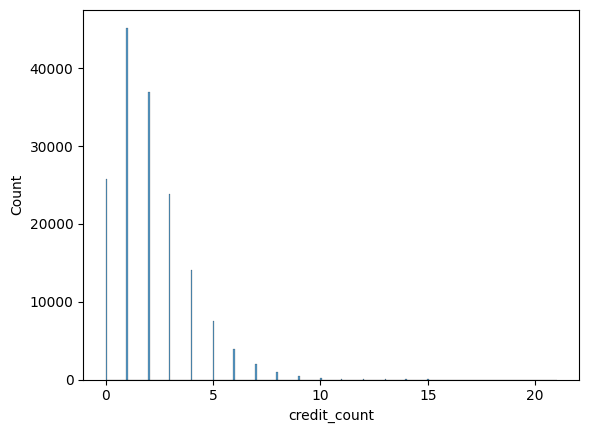

In [ ]:
sns.histplot(data=train_df,x =train_df['credit_count'])

In [ ]:
# Заполнение отсутсвующих значений


In [ ]:
train_df.fillna(method="ffill", inplace= True)

In [ ]:
train_df.isnull().sum()

client_id               0
gender                  0
age                     0
marital_status          0
job_position            0
credit_sum              0
credit_month            0
tariff_id               0
score_shk               0
education               0
living_region           0
monthly_income          0
credit_count            0
overdue_credit_count    0
open_account_flg        0
dtype: int64

<Axes: xlabel='credit_count', ylabel='Count'>

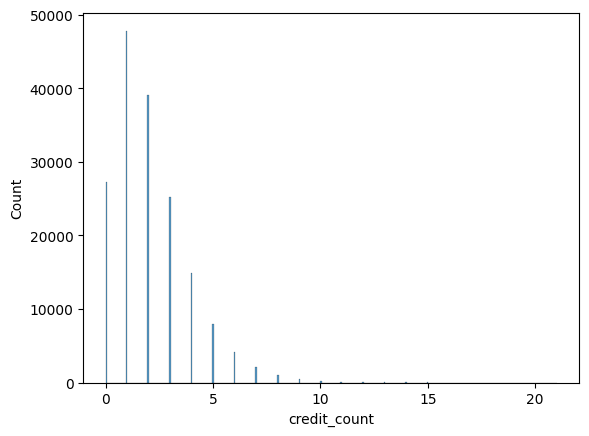

In [ ]:
sns.histplot(data=train_df,x =train_df['credit_count'])

# Работа с вещественными признаками

## Обработка признака living_region

Загружаю новый датасет, где указаны все регионы  РФ и их КЛАДР-коды. Взято с сайта https://github.com/hflabs/region/blob/master/README.md

In [ ]:
region= pd.read_csv('/content/drive/MyDrive/Alif/region.csv', sep=',')

In [ ]:
region.head()

,name,type,name_with_type,federal_district,kladr_id,fias_id,okato,oktmo,tax_office,postal_code,iso_code,timezone,geoname_code,geoname_id,geoname_name
0,Адыгея,Респ,Респ Адыгея,Южный,100000000000,d8327a56-80de-4df2-815c-4f6ab1224c50,79000000000,79000000,100,385000.0,RU-AD,UTC+3,RU.01,584222,Adygeya Republic
1,Башкортостан,Респ,Респ Башкортостан,Приволжский,200000000000,6f2cbfd8-692a-4ee4-9b16-067210bde3fc,80000000000,80000000,200,452000.0,RU-BA,UTC+5,RU.08,578853,Bashkortostan Republic
2,Бурятия,Респ,Респ Бурятия,Дальневосточный,300000000000,a84ebed3-153d-4ba9-8532-8bdf879e1f5a,81000000000,81000000,300,671000.0,RU-BU,UTC+8,RU.11,2050915,Buryatiya Republic
3,Алтай,Респ,Респ Алтай,Сибирский,400000000000,5c48611f-5de6-4771-9695-7e36a4e7529d,84000000000,84000000,400,649000.0,RU-AL,UTC+7,RU.03,1506272,Altai
4,Дагестан,Респ,Респ Дагестан,Северо-Кавказский,500000000000,0bb7fa19-736d-49cf-ad0e-9774c4dae09b,82000000000,82000000,500,368000.0,RU-DA,UTC+3,RU.17,567293,Dagestan


In [ ]:
region['name'].value_counts()

Адыгея            1
Омская            1
Самарская         1
Рязанская         1
Ростовская        1
                 ..
Амурская          1
Хабаровский       1
Ставропольский    1
Приморский        1
Байконур          1
Name: name, Length: 86, dtype: int64

In [ ]:
region['federal_district'].value_counts()

Центральный          18
Приволжский          14
Дальневосточный      11
Северо-Западный      11
Сибирский            10
Южный                 8
Северо-Кавказский     7
Уральский             6
Name: federal_district, dtype: int64

In [ ]:
region['name'][region['name']=='Саха /Якутия/']='Якутия'

<ipython-input-22-ddf4c69b193b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region['name'][region['name']=='Саха /Якутия/']='Якутия'


In [ ]:
train_df['living_region'].value_counts()

ОБЛ МОСКОВСКАЯ          12228
КРАСНОДАРСКИЙ КРАЙ       7457
САНКТ-ПЕТЕРБУРГ          5632
МОСКВА                   5529
ТАТАРСТАН РЕСП           5187
                        ...  
ИНГУШЕТИЯ РЕСП              1
КИРОВСКАЯ ОБЛАСТЬ           1
ОБЛ. МУРМАНСКАЯ             1
КАРЕЛИЯ                     1
КАЛИНИНГРАДСКАЯ ОБЛ.        1
Name: living_region, Length: 301, dtype: int64

In [ ]:
train_df['living_region'].unique()

array(['КРАСНОДАРСКИЙ КРАЙ', 'МОСКВА', 'ОБЛ САРАТОВСКАЯ',
       'ОБЛ ВОЛГОГРАДСКАЯ', 'ЧЕЛЯБИНСКАЯ ОБЛАСТЬ', 'СТАВРОПОЛЬСКИЙ КРАЙ',
       'ОБЛ НИЖЕГОРОДСКАЯ', 'МОСКОВСКАЯ ОБЛ',
       'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА', 'КРАЙ СТАВРОПОЛЬСКИЙ',
       'САНКТ-ПЕТЕРБУРГ', 'РЕСП. БАШКОРТОСТАН', 'ОБЛ АРХАНГЕЛЬСКАЯ',
       'ХАНТЫ-МАНСИЙСКИЙ АО', 'РЕСП БАШКОРТОСТАН', 'ПЕРМСКИЙ КРАЙ',
       'РЕСП КАРАЧАЕВО-ЧЕРКЕССКАЯ', 'САРАТОВСКАЯ ОБЛ', 'ОБЛ КАЛУЖСКАЯ',
       'ОБЛ ВОЛОГОДСКАЯ', 'РОСТОВСКАЯ ОБЛ', 'УДМУРТСКАЯ РЕСП',
       'ОБЛ ИРКУТСКАЯ', 'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'ОБЛ МОСКОВСКАЯ',
       'ОБЛ ТЮМЕНСКАЯ', 'ОБЛ БЕЛГОРОДСКАЯ', 'РОСТОВСКАЯ ОБЛАСТЬ',
       'ОБЛ КОСТРОМСКАЯ', 'РЕСП ХАКАСИЯ', 'РЕСПУБЛИКА ТАТАРСТАН',
       'ИРКУТСКАЯ ОБЛАСТЬ', 'ОБЛ СВЕРДЛОВСКАЯ', 'ОБЛ ПСКОВСКАЯ',
       'КРАЙ ЗАБАЙКАЛЬСКИЙ', 'СВЕРДЛОВСКАЯ ОБЛ', 'ОБЛ ОРЕНБУРГСКАЯ',
       'ОБЛ ВОРОНЕЖСКАЯ', 'ОБЛ АСТРАХАНСКАЯ', 'ОБЛ НОВОСИБИРСКАЯ',
       'ОБЛ ЧЕЛЯБИНСКАЯ', 'ОРЕНБУРГСКАЯ ОБЛ', 'СВЕРДЛОВСКАЯ ОБЛАСТЬ'

In [ ]:
region.shape[0]

86

In [ ]:
# беру первые 6 букв в названии каждого региона - это будет паттерн

for i in range(region.shape[0]):
    region['type'][i]=region['name'][i][:6]

<ipython-input-26-f9bc2d47e03c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region['type'][i]=region['name'][i][:6]


In [ ]:
region['type']

0     Адыгея
1     Башкор
2     Буряти
3      Алтай
4     Дагест
       ...  
81    Чукотс
82    Ямало-
83      Крым
84    Севаст
85    Байкон
Name: type, Length: 86, dtype: object

In [ ]:
# создаю словарь из паттернов, где каждому региону соответсвует паттерн - это ключ.
#  Напремер Башкортостан- башкор
# Каждому ключу соответсвует  КЛАДР-код

reg_dict=dict()
a=list()
for ind, i in enumerate(region['type']):
    reg=r"[\s\w-]*"+str(i).lower()+r"*[\s\w-]*.$"
    reg_dict[reg]=region['kladr_id'][ind]/100000000000

In [ ]:
train_df['living_region']=train_df['living_region'].str.lower()

In [ ]:
# Замена названий региона на КЛАДР-код

train_df.replace(regex=reg_dict, inplace=True)

In [ ]:
train_df['living_region'].unique()

array([24.0, 77.0, 64.0, 34.0, 74.0, 26.0, 52.0, 50.0, 86.0, 78.0, 2.0,
       29.0, 59.0, 9.0, 40.0, 35.0, 61.0, 18.0, 38.0,
       'приволжский федеральный округ', 72.0, 31.0, 44.0, 19.0, 16.0,
       66.0, 60.0, 75.0, 56.0, 36.0, 30.0, 54.0, 45.0, 73.0, 51.0, 3.0,
       14.0, 28.0, 27.0, 83.0, 63.0, 69.0, 76.0, 33.0, 47.0, 57.0, 42.0,
       55.0, 20.0, 46.0, 71.0, 1.0, 11.0, 25.0, 67.0, 43.0, 5.0, 58.0,
       10.0, 49.0, 12.0, 37.0, 79.0, 4.0, 7.0, 68.0, 17.0, 53.0, 48.0,
       'саха /якутия/ респ', 15.0, 62.0, 65.0, 21.0, 41.0, 13.0, 8.0,
       32.0, 39.0, 87.0, 'горьковская обл', 'сев. осетия - алания', 6.0,
       'россия', 'читинская обл', '98', 'мытищинский р-н',
       'республика саха', 'эвенкийский ао', 'гусь-хрустальный р-н',
       'орёл', 'дальний восток', '74'], dtype=object)

In [ ]:
train_df['living_region'].value_counts().tail(15)

87.0                             32
20.0                             31
6.0                              19
горьковская обл                  19
читинская обл                    17
россия                            2
приволжский федеральный округ     1
98                                1
мытищинский р-н                   1
республика саха                   1
эвенкийский ао                    1
гусь-хрустальный р-н              1
орёл                              1
дальний восток                    1
74                                1
Name: living_region, dtype: int64

In [ ]:
# Некоторые области имеют устаревшее название, которого не оказалось в файле.
# Также нектороые не находятся из-за слеша в названии, кол-ва букв
# Ихпридется заменить вручную

train_df['living_region'][train_df['living_region']=='горьковская обл']=52

train_df['living_region'][train_df['living_region']=='читинская обл']=75

train_df['living_region'][train_df['living_region']=='сев. осетия - алания']=15
train_df['living_region'][train_df['living_region']=='саха /якутия/ респ']=14

train_df['living_region'][train_df['living_region']=='республика саха']=14


<ipython-input-38-438f6a4e7a18>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['living_region'][train_df['living_region']=='горьковская обл']=52
<ipython-input-38-438f6a4e7a18>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['living_region'][train_df['living_region']=='читинская обл']=75
<ipython-input-38-438f6a4e7a18>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['living_region'][train_df['living_regio

In [ ]:
train_df['living_region'].value_counts().tail(15)

79.0                             203
49.0                             159
5.0                               69
87.0                              32
20.0                              31
6.0                               19
россия                             2
приволжский федеральный округ      1
98                                 1
мытищинский р-н                    1
эвенкийский ао                     1
гусь-хрустальный р-н               1
орёл                               1
дальний восток                     1
74                                 1
Name: living_region, dtype: int64

In [ ]:
train_df['living_region'].unique()

array([24.0, 77.0, 64.0, 34.0, 74.0, 26.0, 52.0, 50.0, 86.0, 78.0, 2.0,
       29.0, 59.0, 9.0, 40.0, 35.0, 61.0, 18.0, 38.0,
       'приволжский федеральный округ', 72.0, 31.0, 44.0, 19.0, 16.0,
       66.0, 60.0, 75.0, 56.0, 36.0, 30.0, 54.0, 45.0, 73.0, 51.0, 3.0,
       14.0, 28.0, 27.0, 83.0, 63.0, 69.0, 76.0, 33.0, 47.0, 57.0, 42.0,
       55.0, 20.0, 46.0, 71.0, 1.0, 11.0, 25.0, 67.0, 43.0, 5.0, 58.0,
       10.0, 49.0, 12.0, 37.0, 79.0, 4.0, 7.0, 68.0, 17.0, 53.0, 48.0,
       15.0, 62.0, 65.0, 21.0, 41.0, 13.0, 8.0, 32.0, 39.0, 87.0, 6.0,
       'россия', '98', 'мытищинский р-н', 'эвенкийский ао',
       'гусь-хрустальный р-н', 'орёл', 'дальний восток', '74'],
      dtype=object)

In [ ]:
mask=train_df['living_region'].value_counts()[train_df['living_region'].value_counts()<3]

In [ ]:
# Удаляю след данные поскольку их невозможно восстановить. Ну и их по 1 штуке всего

mask.index

Index(['россия', 'приволжский федеральный округ', '98', 'мытищинский р-н',
       'эвенкийский ао', 'гусь-хрустальный р-н', 'орёл', 'дальний восток',
       '74'],
      dtype='object')

In [ ]:
train_df=train_df[~train_df['living_region'].isin(list(mask.index))]
train_df.reset_index(inplace=True, drop=True)

In [ ]:
# Сохранение и чтение
train_df.to_csv('/content/drive/MyDrive/Alif/train_df.csv')

In [ ]:
train_df= pd.read_csv('/content/drive/MyDrive/Alif/train_df.csv', sep=',', encoding='windows-1251')
train_df.drop('Unnamed: 0', inplace= True,axis=1)

In [ ]:
train_df

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,48,MAR,UMN,59998.00,10,1.60,0.770249,GRD,24.0,30000.0,1.0,1.0,0
1,2,F,28,MAR,UMN,10889.00,6,1.10,0.248514,GRD,77.0,43000.0,2.0,0.0,0
2,3,M,32,MAR,SPC,10728.00,12,1.10,0.459589,SCH,64.0,23000.0,5.0,0.0,0
3,4,F,27,DIV,SPC,12009.09,12,1.10,0.362536,GRD,34.0,17000.0,2.0,0.0,0
4,5,M,45,MAR,SPC,16908.89,10,1.10,0.421385,SCH,74.0,25000.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170538,170742,F,27,UNM,SPC,64867.00,12,1.10,0.535257,GRD,16.0,40000.0,6.0,0.0,0
170539,170743,F,24,MAR,SPC,17640.00,6,1.60,0.573287,SCH,78.0,30000.0,1.0,0.0,0
170540,170744,F,31,UNM,SPC,27556.47,10,1.32,0.416098,GRD,25.0,40000.0,1.0,0.0,0
170541,170745,F,53,DIV,PNA,6189.00,12,1.10,0.482595,SCH,58.0,31000.0,2.0,0.0,0


In [ ]:
data_obj = train_df.select_dtypes(include='object')
data_obj['open_account_flg']=train_df['open_account_flg']

In [ ]:
data_obj

,gender,marital_status,job_position,education,open_account_flg
0,M,MAR,UMN,GRD,0
1,F,MAR,UMN,GRD,0
2,M,MAR,SPC,SCH,0
3,F,DIV,SPC,GRD,0
4,M,MAR,SPC,SCH,0
...,...,...,...,...,...
170538,F,UNM,SPC,GRD,0
170539,F,MAR,SPC,SCH,0
170540,F,UNM,SPC,GRD,0
170541,F,DIV,PNA,SCH,0


## Работа с  остальными вещественными признаками

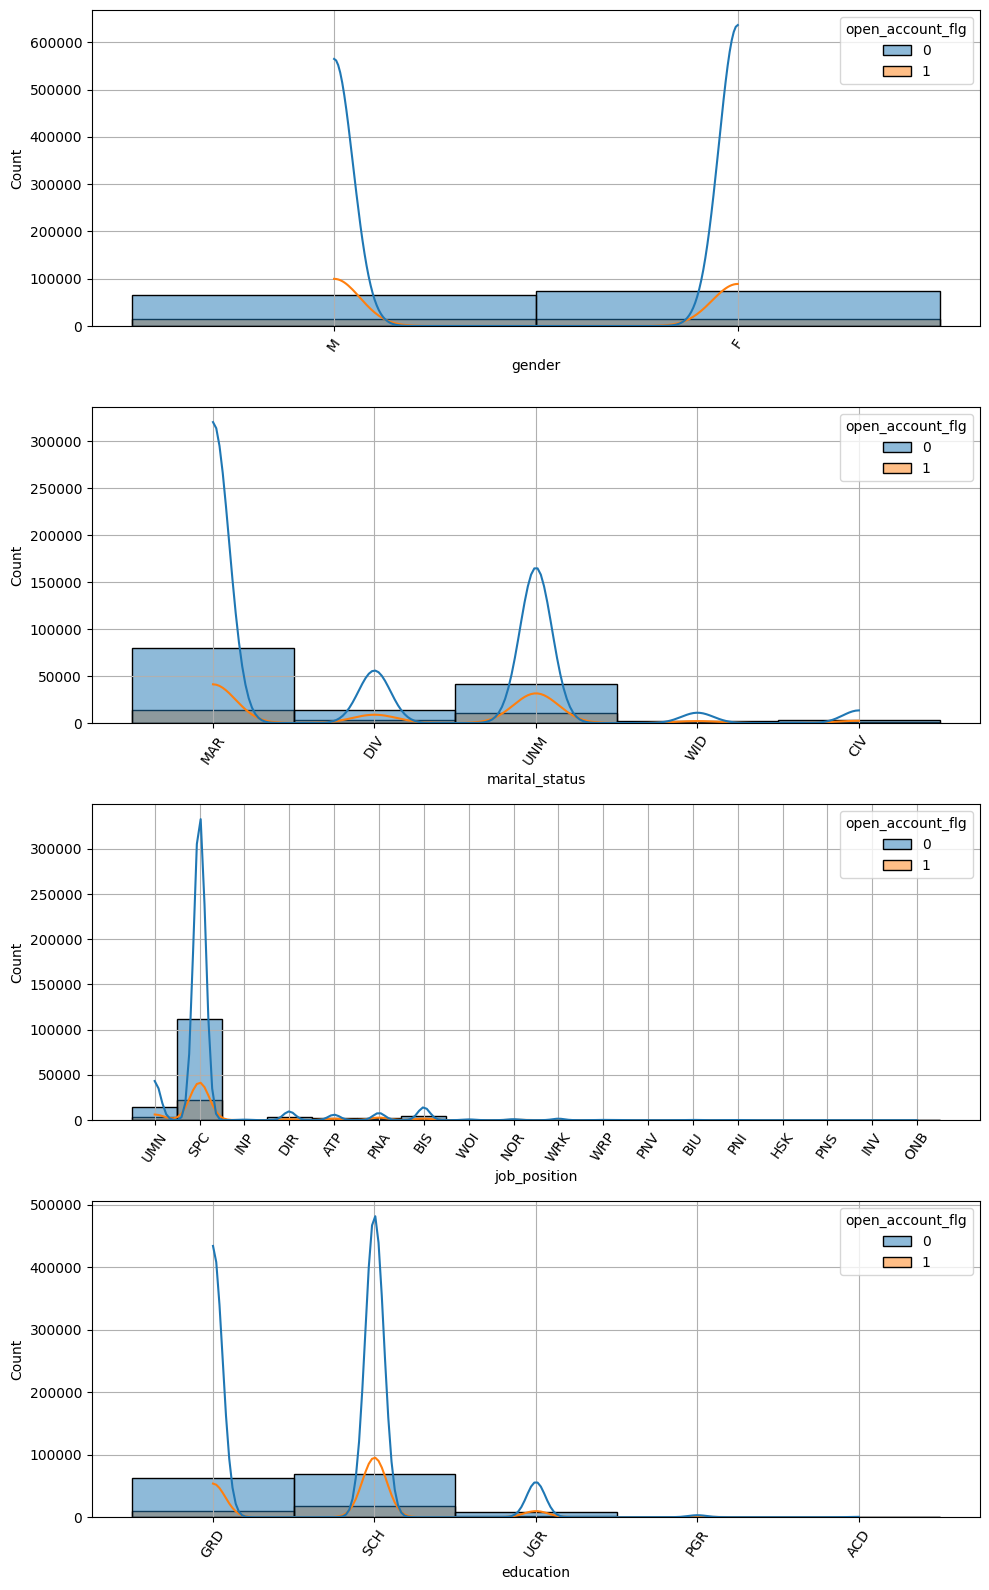

In [ ]:
# Графики количества наблюдений в каждом вещественном признаке

fig, ax = plt.subplots(nrows=data_obj.shape[1]-1, ncols=1, squeeze=False, figsize=[10, 16])
a=0
for i in data_obj.iloc[:,:-1]:
    #sns.countplot(data=data_obj, y=i, ax=ax[a,0], hue='open_account_flg', dodge=False)
    sns.histplot(data=data_obj,x=i, ax=ax[a,0], hue='open_account_flg', kde=True)
    #sns.histplot(data=data_obj,y=data_obj[i], ax=ax[a,0], hue='open_account_flg', kde=True)
    ax[a,0].grid(True)
    ax[a,0].tick_params(axis='x', rotation=55)
    plt.tight_layout()
    a+=1
plt.show()

 Исходя из графиков, можно сказать:
*  график переменной региона имеет разную форму распределения в зависимости от целевой переменной
* мужчины чаще берут кредит
* для других признаков целевая переменная распределена равномерно

In [ ]:
data_obj['gender'][data_obj['gender']=='M']=1
data_obj['gender'][data_obj['gender']=='F']=0
data_obj['gender']=data_obj['gender'].astype('int64')

<ipython-input-30-a2ab7c5dc0d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_obj['gender'][data_obj['gender']=='M']=1
<ipython-input-30-a2ab7c5dc0d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_obj['gender'][data_obj['gender']=='F']=0


# Работа с числовыми данными

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170543 entries, 0 to 170542
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170543 non-null  int64  
 1   gender                170543 non-null  object 
 2   age                   170543 non-null  int64  
 3   marital_status        170543 non-null  object 
 4   job_position          170543 non-null  object 
 5   credit_sum            170543 non-null  float64
 6   credit_month          170543 non-null  int64  
 7   tariff_id             170543 non-null  float64
 8   score_shk             170543 non-null  float64
 9   education             170543 non-null  object 
 10  living_region         170543 non-null  float64
 11  monthly_income        170543 non-null  float64
 12  credit_count          170543 non-null  float64
 13  overdue_credit_count  170543 non-null  float64
 14  open_account_flg      170543 non-null  int64  
dtype

In [ ]:
train_nums = train_df.select_dtypes(include=['float64','int64'])

In [ ]:
train_nums

,client_id,age,credit_sum,credit_month,tariff_id,score_shk,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,48,59998.00,10,1.60,0.770249,24.0,30000.0,1.0,1.0,0
1,2,28,10889.00,6,1.10,0.248514,77.0,43000.0,2.0,0.0,0
2,3,32,10728.00,12,1.10,0.459589,64.0,23000.0,5.0,0.0,0
3,4,27,12009.09,12,1.10,0.362536,34.0,17000.0,2.0,0.0,0
4,5,45,16908.89,10,1.10,0.421385,74.0,25000.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
170538,170742,27,64867.00,12,1.10,0.535257,16.0,40000.0,6.0,0.0,0
170539,170743,24,17640.00,6,1.60,0.573287,78.0,30000.0,1.0,0.0,0
170540,170744,31,27556.47,10,1.32,0.416098,25.0,40000.0,1.0,0.0,0
170541,170745,53,6189.00,12,1.10,0.482595,58.0,31000.0,2.0,0.0,0


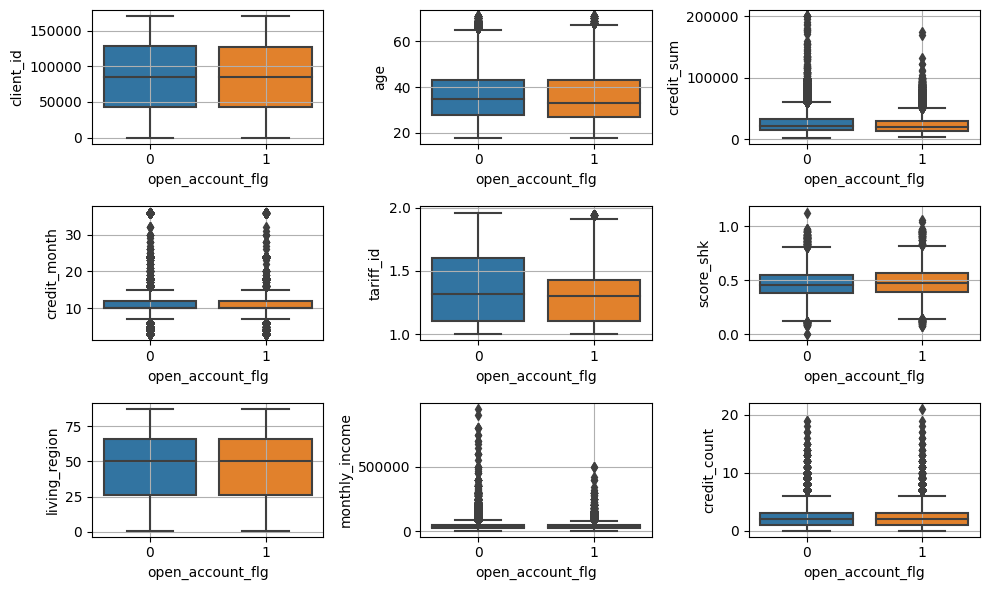

In [ ]:
# Боксплоты для числовых признаков

plt.figure(figsize=(10, 6))
for i in np.arange(0,9):
    plt.subplot(3,3,i+1)
    sns.boxplot(data=train_nums, x='open_account_flg', y=train_nums.columns[i],width = 0.8)
    plt.grid(True)
    plt.tight_layout()


* После уровня ежемесячного дохода в 500 000 категория 1 исчезает на графике боксплот, это та граница, когда  человеку не нужен кредит, тк он в состояния приобретать товары без него
* самой важной фичей является traffic_id поскольку графики отличаются сильнее всего и менее всего выбросов
* меньше всего влияет фича age, тк графики более всех остальных повторяют друг друга
* кол-во просроченных кредитов для основной массы людей = 0, для остальный 1,2,3

In [ ]:
train_nums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170543 entries, 0 to 170542
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170543 non-null  int64  
 1   age                   170543 non-null  int64  
 2   credit_sum            170543 non-null  float64
 3   credit_month          170543 non-null  int64  
 4   tariff_id             170543 non-null  float64
 5   score_shk             170543 non-null  float64
 6   monthly_income        170543 non-null  float64
 7   credit_count          170543 non-null  float64
 8   overdue_credit_count  170543 non-null  float64
 9   open_account_flg      170543 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 13.0 MB


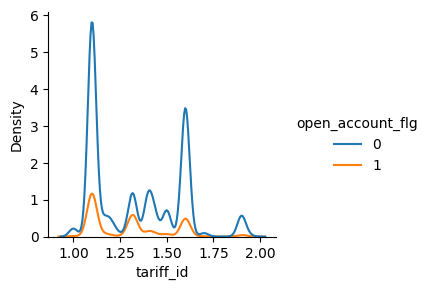

In [ ]:
sns.displot(train_nums, x='tariff_id', hue='open_account_flg', kind='kde', height=3)

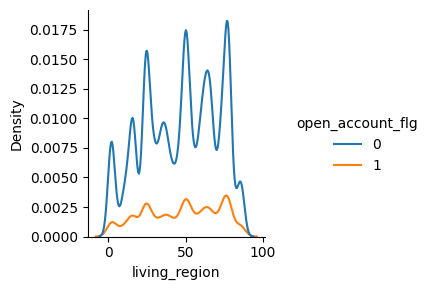

In [ ]:
sns.displot(train_nums, x='living_region', hue='open_account_flg', kind='kde', height=3)

In [ ]:
# Анализ просроченных кредитов

train_df['overdue_credit_count'].value_counts()

0.0    163354
1.0      7326
2.0        50
3.0         5
Name: overdue_credit_count, dtype: int64

In [ ]:
train_df[train_df['overdue_credit_count']==3]

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
26662,26667,M,33,DIV,SPC,43191.0,6,1.4,0.328984,GRD,86.0,50000.0,4.0,3.0,0
29465,29470,M,25,UNM,SPC,11111.0,6,1.3,0.582469,GRD,77.0,100000.0,4.0,3.0,0
63581,63588,M,29,UNM,SPC,31491.0,12,1.5,0.490006,GRD,66.0,45000.0,6.0,3.0,0
65301,65308,M,33,DIV,SPC,43191.0,6,1.6,0.328984,GRD,86.0,50000.0,4.0,3.0,0
83005,83013,M,29,UNM,SPC,31491.0,6,1.1,0.490006,GRD,66.0,45000.0,6.0,3.0,1


* Самое большое кол-во просроченых кредитов (3) наблюдаются у мужчин, 25-35 лет, неженатых или разведенных, из Москвы, Мо, Ханты-Мансийский Автономного Округа - Югра,Свердловской Обл

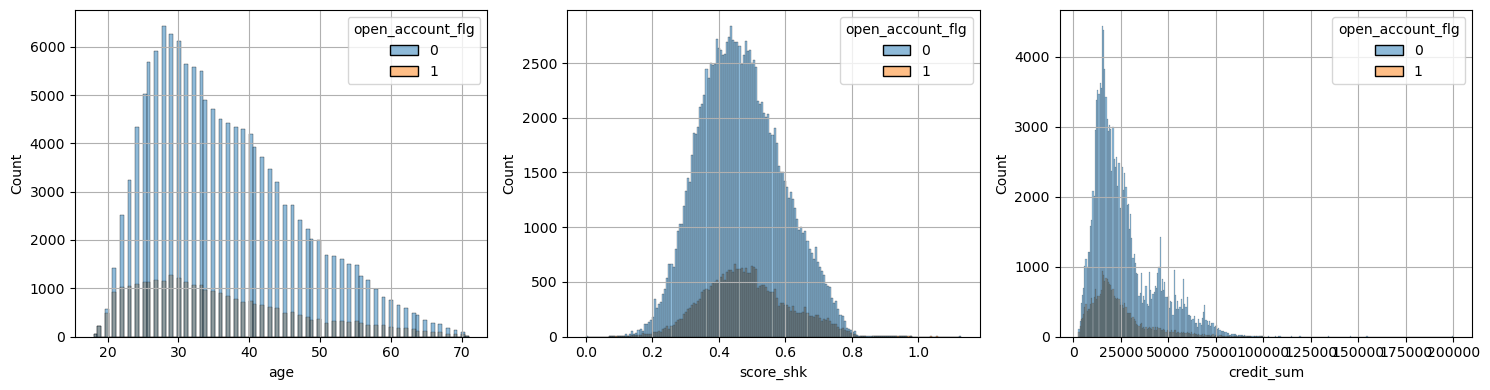

In [ ]:
train_nums_3=train_nums[['age', 'score_shk', 'credit_sum','open_account_flg']]
plt.figure(figsize=(15, 4))
for i in np.arange(0,3):
    plt.subplot(1,3,i+1)
    sns.histplot(data=train_nums_3,x =train_nums_3.columns[i], hue='open_account_flg')
    plt.grid(True)
    plt.tight_layout()

* загадочная фича 'score_shk' имеет идеальное гаусово распределние - некая оценка клиентов?

In [ ]:
# Окончательный набор данных имеет все числовые признаки,признак региона и признак пола

#dataset_fin=pd.concat([train_nums, data_obj['living_region'], nom_data_obj], axis=1)
dataset_fin=pd.concat([train_nums,  data_obj['gender']], axis=1)

In [ ]:
dataset_fin.drop('client_id', axis=1, inplace= True )

In [ ]:
dataset_fin

,age,credit_sum,credit_month,tariff_id,score_shk,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender
0,48,59998.00,10,1.60,0.770249,24.0,30000.0,1.0,1.0,0,1
1,28,10889.00,6,1.10,0.248514,77.0,43000.0,2.0,0.0,0,0
2,32,10728.00,12,1.10,0.459589,64.0,23000.0,5.0,0.0,0,1
3,27,12009.09,12,1.10,0.362536,34.0,17000.0,2.0,0.0,0,0
4,45,16908.89,10,1.10,0.421385,74.0,25000.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
170538,27,64867.00,12,1.10,0.535257,16.0,40000.0,6.0,0.0,0,0
170539,24,17640.00,6,1.60,0.573287,78.0,30000.0,1.0,0.0,0,0
170540,31,27556.47,10,1.32,0.416098,25.0,40000.0,1.0,0.0,0,0
170541,53,6189.00,12,1.10,0.482595,58.0,31000.0,2.0,0.0,0,0


In [ ]:
# Сохранение и чтение
dataset_fin.to_csv('/content/drive/MyDrive/Alif/dataset_fin.csv')

In [9]:
dataset_fin = pd.read_csv('/content/drive/MyDrive/Alif/dataset_fin.csv',  sep=',',encoding='windows-1251', index_col=0)

In [ ]:
dataset_fin

,age,credit_sum,credit_month,tariff_id,score_shk,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender
0,48,59998.00,10,1.60,0.770249,24.0,30000.0,1.0,1.0,0,1
1,28,10889.00,6,1.10,0.248514,77.0,43000.0,2.0,0.0,0,0
2,32,10728.00,12,1.10,0.459589,64.0,23000.0,5.0,0.0,0,1
3,27,12009.09,12,1.10,0.362536,34.0,17000.0,2.0,0.0,0,0
4,45,16908.89,10,1.10,0.421385,74.0,25000.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
170538,27,64867.00,12,1.10,0.535257,16.0,40000.0,6.0,0.0,0,0
170539,24,17640.00,6,1.60,0.573287,78.0,30000.0,1.0,0.0,0,0
170540,31,27556.47,10,1.32,0.416098,25.0,40000.0,1.0,0.0,0,0
170541,53,6189.00,12,1.10,0.482595,58.0,31000.0,2.0,0.0,0,0


# Построение моделей

In [ ]:
## кол-во элементов в каждом классе целевой переменной

dataset_fin['open_account_flg'].value_counts()

0    140491
1     30052
Name: open_account_flg, dtype: int64

In [ ]:
dataset_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170543 entries, 0 to 170542
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   age                   170543 non-null  int64  
 1   credit_sum            170543 non-null  float64
 2   credit_month          170543 non-null  int64  
 3   tariff_id             170543 non-null  float64
 4   score_shk             170543 non-null  float64
 5   living_region         170543 non-null  float64
 6   monthly_income        170543 non-null  float64
 7   credit_count          170543 non-null  float64
 8   overdue_credit_count  170543 non-null  float64
 9   open_account_flg      170543 non-null  int64  
 10  gender                170543 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 15.6 MB


In [10]:
# Деление всего набора на тренировочный и тестовый

def split(scaled_data):
    train_df, test_df = train_test_split(scaled_data, test_size=0.3, stratify=scaled_data['open_account_flg'], shuffle=True, random_state=RANDOM_SEED)
    return train_df, test_df

In [11]:
# Деление на данные и метки для них

df_train, df_test=split(dataset_fin)
TARGET_COLUMN='open_account_flg'
x_columns = dataset_fin.columns
x_columns = x_columns[x_columns != TARGET_COLUMN]
y_scal_tren = df_train[TARGET_COLUMN]
X_scal_tren = df_train[x_columns]
y_scal_test = df_test[TARGET_COLUMN]
X_scal_test = df_test[x_columns]

In [12]:
#функция обучения модели и получения спрогнозированных значений

def pred(model, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test):
    model.fit(X_scal_tren, y_scal_tren)
    y_pred = model.predict(X_scal_test)
    report = classification_report(y_scal_test, y_pred, digits=5)
    return print(report),  y_pred

In [ ]:
rf_clf = RandomForestClassifier(max_depth=14, n_estimators=90, max_features='sqrt',
                                random_state=RANDOM_SEED)
_,y_pred_rf_clf=pred(rf_clf, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

              precision    recall  f1-score   support

           0    0.83067   0.99245   0.90438     42147
           1    0.60595   0.05424   0.09956      9016

    accuracy                        0.82712     51163
   macro avg    0.71831   0.52335   0.50197     51163
weighted avg    0.79107   0.82712   0.76256     51163



In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=90, max_depth=14, max_features='sqrt', random_state=RANDOM_SEED)
_,y_pred_gb_clf=pred(gb_clf, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

              precision    recall  f1-score   support

           0    0.83674   0.97139   0.89905     42147
           1    0.46016   0.11402   0.18276      9016

    accuracy                        0.82030     51163
   macro avg    0.64845   0.54270   0.54090     51163
weighted avg    0.77038   0.82030   0.77282     51163



In [13]:
L_gbm= lgb.LGBMClassifier()
_,y_pred_lgb = pred(L_gbm, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

[LightGBM] [Info] Number of positive: 21036, number of negative: 98344
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 119380, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176210 -> initscore=-1.542236
[LightGBM] [Info] Start training from score -1.542236
              precision    recall  f1-score   support

           0    0.83244   0.99110   0.90487     42147
           1    0.61851   0.06744   0.12161      9016

    accuracy                        0.82833     51163
   macro avg    0.72548   0.52927   0.51324     51163
weighted avg    0.79474   0.82833   0.76684     51163



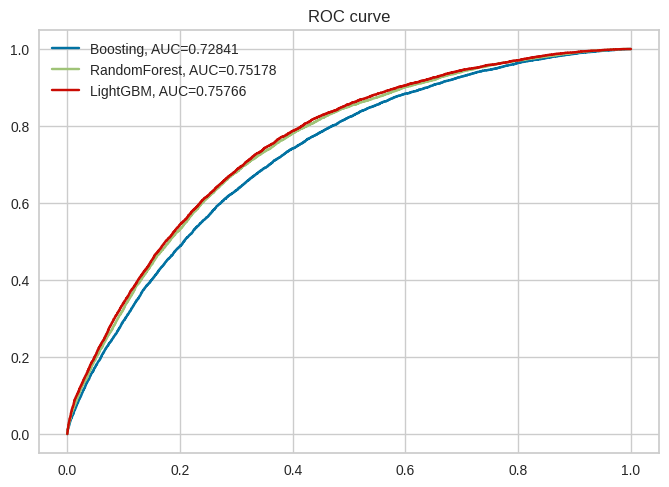

In [ ]:

y_pred4 = rf_clf.predict_proba(X_scal_test)[:, 1]
y_pred2=gb_clf.predict_proba(X_scal_test)[:, 1]
y_pred5=L_gbm.predict_proba(X_scal_test)[:, 1]

fpr2, tpr2, _ = metrics.roc_curve(y_scal_test, y_pred2)
fpr4, tpr4, _ = metrics.roc_curve(y_scal_test, y_pred4)
fpr5, tpr5, _ = metrics.roc_curve(y_scal_test, y_pred5)

auc2 = round(metrics.roc_auc_score(y_scal_test, y_pred2), 5)
auc4 = round(metrics.roc_auc_score(y_scal_test, y_pred4), 5)
auc5 = round(metrics.roc_auc_score(y_scal_test, y_pred5), 5)


plt.plot(fpr2,tpr2,label="Boosting, AUC="+str(auc2))
plt.plot(fpr4,tpr4,label="RandomForest, AUC="+str(auc4))
plt.plot(fpr5,tpr5,label="LightGBM, AUC="+str(auc5))
plt.title('ROC curve')
plt.legend()


    
* Самый высокий показатель AUC  у LightGBM, также это самый быстрый классификатор
* Самый низкий показатель AUC  у логистической регрессии
* поскольку наблюдается дисбаланс классов:
    * логистическая регрессия не предсказывает 1 класс;
    * модель опорных векторов использовать невозможно;





# Изменение гиперпараметров для LightGBM

Так как самым быстрым и точным алгоритмом оказался LightGBM, использую его для настройки гиперпараметров для получения большего AUC

In [16]:
L_gbm_new= lgb.LGBMClassifier(reg_alpha=1, reg_lambda=0.6)
_,y_pred_lgb_new = pred(L_gbm_new, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

[LightGBM] [Info] Number of positive: 21036, number of negative: 98344
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 119380, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176210 -> initscore=-1.542236
[LightGBM] [Info] Start training from score -1.542236
              precision    recall  f1-score   support

           0    0.83220   0.99091   0.90465     42147
           1    0.60838   0.06599   0.11907      9016

    accuracy                        0.82792     51163
   macro avg    0.72029   0.52845   0.51186     51163
weighted avg    0.79276   0.82792   0.76621     51163



In [17]:
y_pred_lgb = L_gbm_new.predict_proba(X_scal_test)[:, 1]
auc = round(metrics.roc_auc_score(y_scal_test, y_pred_lgb), 5)
auc

0.75805

In [ ]:
# Предыдущая auc

auc5

0.75766

Изменение в 3 знаке после запятой с помощью добавления коэффициентов регуляризации L1, L2 и GridSearchCV

# Изменение порога

Построю кривую recall - precision для положительного класа

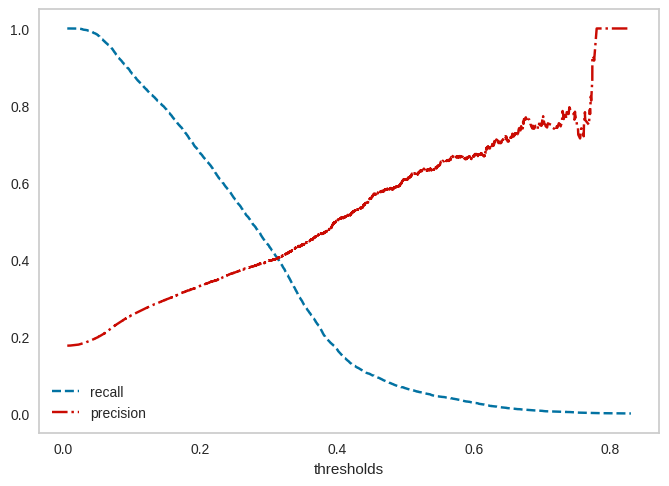

In [ ]:

precision, recall, thresholds = precision_recall_curve(y_scal_test, y_pred_lgb)
plt.plot(thresholds, recall[0:-1],'b--',label='recall')
plt.plot(thresholds,precision[0:-1],'r-.',label='precision')
plt.xlabel("thresholds")
plt.grid()
plt.legend()
plt.show()

In [ ]:
def predict_threshold(y_probs, threshold):
    result=[]
    for i in y_probs:
        if i>=threshold:
            result.append(1)
        else:
            result.append(0)
    return result

In [ ]:
#изменение порога
y_pred_03 = predict_threshold(y_pred, 0.3)

In [ ]:
print(classification_report(y_scal_test, y_pred_03, digits=5))

              precision    recall  f1-score   support

           0    0.92887   0.60476   0.73257     42147
           1    0.29778   0.78350   0.43155      9016

    accuracy                        0.63626     51163
   macro avg    0.61332   0.69413   0.58206     51163
weighted avg    0.81766   0.63626   0.67952     51163



# Интерпретация

важности признаков
во время тренировки можно получить  с омощью feature_importances_

In [ ]:
def Interpret(importances):
  plt.figure(figsize=(10, 5))
  for i,v in enumerate(importances):
    plt.bar([x for x in X_scal_test.columns], importances)
  plt.xticks(rotation=40)
  plt.show()

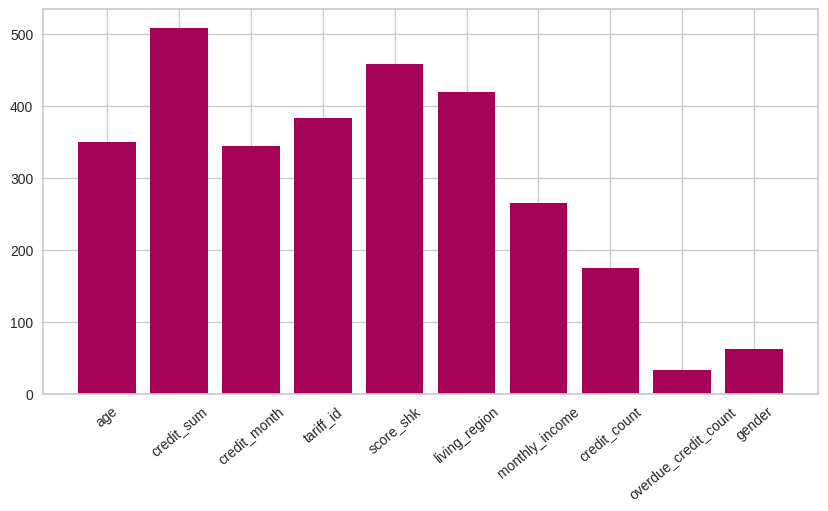

In [ ]:
# График для модели LightGBM с регуляризацией

Interpret(L_gbm_new.feature_importances_)

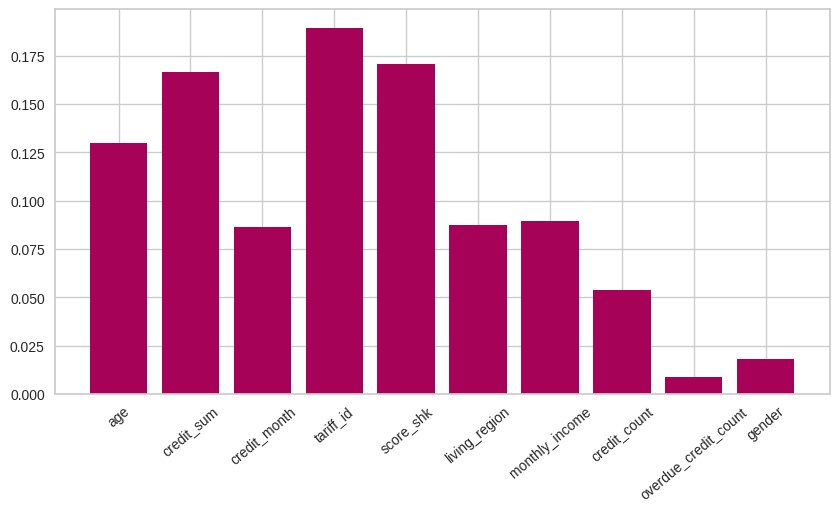

In [ ]:
# График для модели RandomForest

Interpret(rf_clf.feature_importances_)

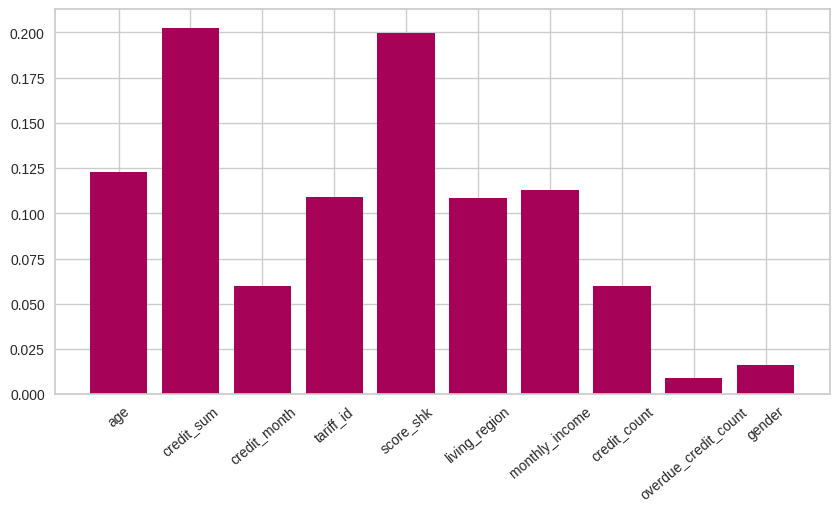

In [ ]:
# График для модели GradientBoosting

Interpret(gb_clf.feature_importances_)

Пол и кол-во просроченных кредитов менее всего влияют на любую из моделей

In [ ]:
# Строю матрицу корреляции

def matrix(y_scal_test, y_pred):
  sns.heatmap(confusion_matrix(y_scal_test, y_pred),
            annot=True,
            fmt='g',
            xticklabels=['not credit','credit'],
            yticklabels=['not credit','credit'])
  plt.ylabel('Actual',fontsize=13)
  plt.xlabel(' Prediction',fontsize=13)
  plt.title('Confusion Matrix',fontsize=17)
  plt.show()


In [ ]:
y_scal_test.value_counts()

0    42147
1     9016
Name: open_account_flg, dtype: int64

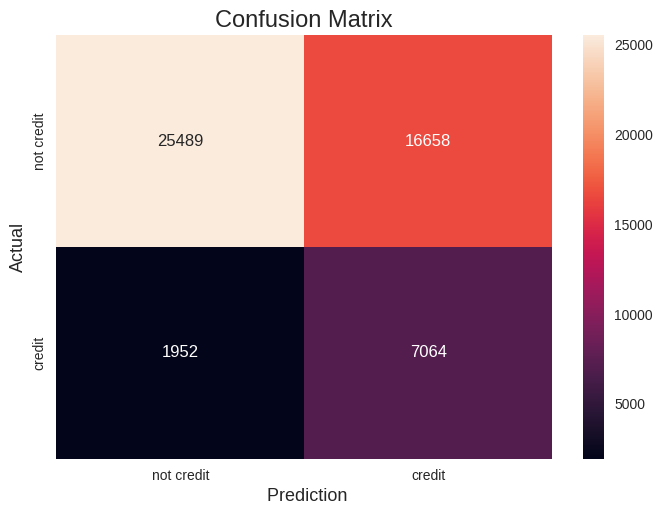

In [ ]:
# Матрица кореляци для измененного порога в 0.3

matrix(y_scal_test, y_pred_03)


Если цель не пропустить человека который берет/выплачивает кредит, то модель верно прогнозирует 1 (true positive) 7064 реальных кредитов, 1952 прогнозируются как некредиты и 16658 спрогнозированы как кредиты, но ими не являются

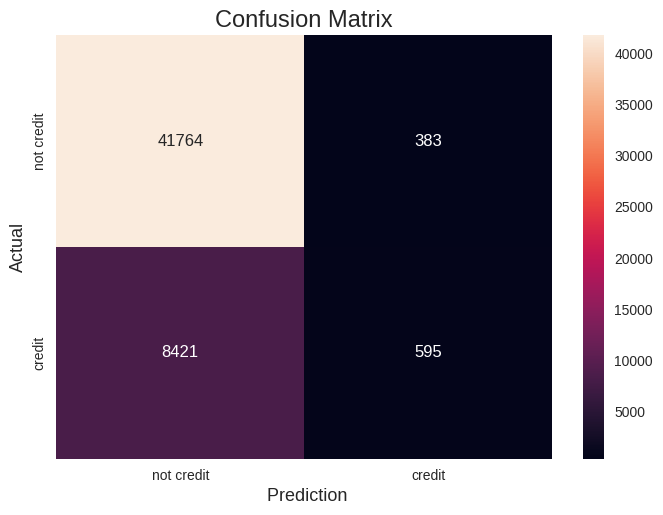

(None,)

In [ ]:
# Матрица кореляци для неизмененного порога в 0.5

matrix(y_scal_test, y_pred_lgb_new),


Если брать модель с дефолтным порогом в 0.5, то только 595 кредитов верно прогнозируются, модель ориентирована на нули, то есть не дает никому кредитов

# Работа с несбалансированным набором

In [14]:
# Работа с весами

default_wt = 1 / np.mean(df_train.open_account_flg == 1)
wt = [default_wt if outcome == 1 else 1 for outcome in df_train.open_account_flg]

In [18]:
L_gbm_new.fit(X_scal_tren, y_scal_tren, wt)
y_pred = L_gbm_new.predict(X_scal_test)
report = classification_report(y_scal_test, y_pred, digits=5)

[LightGBM] [Info] Number of positive: 21036, number of negative: 98344
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 119380, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.548309 -> initscore=0.193840
[LightGBM] [Info] Start training from score 0.193840


In [ ]:
print(report)

              precision    recall  f1-score   support

           0    0.92887   0.60476   0.73257     42147
           1    0.29778   0.78350   0.43155      9016

    accuracy                        0.63626     51163
   macro avg    0.61332   0.69413   0.58206     51163
weighted avg    0.81766   0.63626   0.67952     51163



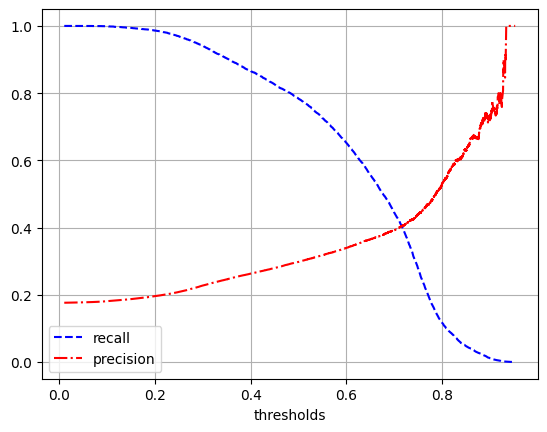

In [19]:
y_pred_w = L_gbm_new.predict_proba(X_scal_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_scal_test, y_pred_w)
plt.plot(thresholds, recall[0:-1],'b--',label='recall')
plt.plot(thresholds,precision[0:-1],'r-.',label='precision')
plt.xlabel("thresholds")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Использование SMOTE

from imblearn.over_sampling import SMOTE

In [ ]:
X_resampled, y_resampled = SMOTE().fit_resample(X_scal_tren, y_scal_tren)

In [ ]:
y_resampled.value_counts()

0    98344
1    98344
Name: open_account_flg, dtype: int64

In [ ]:
_,y_pred_smote=pred(L_gbm_new, X_resampled, y_resampled, X_scal_test, y_scal_test)

[LightGBM] [Info] Number of positive: 98344, number of negative: 98344
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1874
[LightGBM] [Info] Number of data points in the train set: 196688, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0    0.83486   0.97948   0.90140     42147
           1    0.49563   0.09428   0.15842      9016

    accuracy                        0.82349     51163
   macro avg    0.66524   0.53688   0.52991     51163
weighted avg    0.77508   0.82349   0.77047     51163



Вывод: оба метода не дали какого-от весомого преимущества

Вывод: самая лучшая модель - LightGBM с изменненными гиперпараметрами и порогом в 0.3